In [ ]:
!pip install d2l==1.0.0-alpha0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 15. Natural Language Processing : Pretraining

## Introduction

사람들은 의사소통할 필요가 있습니다.

사람들에 대한 기본적인 조건이기도 하지만, 많은 양의 text가 매일 생성되어 왔습니다.

미디어, 채팅 앱, 이메일, 리뷰, 뉴스, 논문, 책에 있는 풍부한 text를 주면, 컴퓨터가 사람들의 언어에 기반으로 text를 이해해서 도움을 주거나 결정을 내릴 수 있습니다.

---

NLP는 자연어를 사용하는 컴퓨터와 사람 사이의 상호작용을 연구합니다.

실질적으로, text 데이터를 처리하거나 분석하기 위해 NLP 기술을 사용하는게 일반적입니다.

---

text를 이해하려면 representation부터 공부해야 합니다.

거대한 말뭉치에있는 text sequence를 활용하기 위해서, 주변의 단어들로 숨겨진 단어가 무엇인지를 예측하는 것같이,Self-Supervised Learning은 text representation을 사전학습하는데 널리 사용되고 있습니다.

이 방법으로, 모델은 비싼 labeling의 노력 없이 엄청난 text data로 지도학습합니다.

---

<img src = 'https://d2l.ai/_images/nlp-map-pretrain.svg' width = '500px' >


이번 장에서는, 각 단어나 subword를 개별 token으로 다룰 때, 개별 token의 representation은 거대한 말뭉치에서 word2vec, GloVe, Subword Embedding Model을 사용하여 pretraining에 사용됩니다.

Pretraining 이후에, 개별 token의 representaion은 vector가 되지만, 문맥을 반영하진 못합니다.<br>(Example : 먹는 배, 타는 배 구별 X)

그래서, 최신의 많은 pretraining 모델들은 다른 문맥에서 동일한 token의 representation을 적용합니다.

그 중하나가 BERT이고, Transformer Encoder를 기반으로 한 더 깊은 Self-Supervised Model입니다.

위에 그림처럼 어떻게 representation을 공부할지 볼 예정입니다.

---

## 15-1. Word Embedding (Word2Vec)

### Introduction

자연어는 의미를 표현하는 복잡한 시스템입니다.

이 시스템에서, 단어는 의미를 가지는 기본 단위입니다.

챕터 이름이 암시하듯이, Word Vector는 단어를 나타내는 벡터이고, 단어의 representation이자 feature vector로 여겨질 수 있습니다.

실제 vector에 단어를 연결하는 기술은 word embedding이라고 불립니다.

최근 몇년간, 단어 임베딩은 NLP의 기본 지식 되어오고 있습니다.

### 1) One Hot Vectors Are a Bad Choice

9.5장에서 단어를 나타내기 위해 one-hot 벡터를 사용했습니다.

단어 사전에 서로 다른 단어의 수가 $N$개라고 가정하면, 각 단어는 $0$부터 $N-1$까지 서로 다른 숫자에 대응(매칭)됩니다.

index $i$를 가지는 단어의 one-hot 벡터 representation을 얻으려면, index i만 1이고 나머지는 0인 길이 $N$의 벡터를 만들어야 합니다.

이 방법으로, 각 단어는 길이가 $N$인 단어로 표현되고, NN에 바로 사용됩니다.

---

One-Hot 단어 벡터가 만들기는 쉽지만, 보통 좋은 선택은 아닙니다.

주된 이유는 우리가 주요 사용하는 Cosine Similarity와 같이 단어 사이의 유사도를 정확히 나타낼 수 없기 때문입니다.

$x,y\in R^d$인 벡터들에게, Cosine 유사도는 그 각도의 Cosine 입니다.

서로 다른 두 단어의 Cosine 유사도는 0이기 때문에, One-Hot Vector는 단어 사이의 유사도를 계산할 수 없습니다.

<br><br>
**단어 $\mathbf{x}$와 단어 $\mathbf{y}$의 Cosine Similarity**

$$\frac{\mathbf{x}^\top \mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|} \in [-1, 1]$$


- 이 값은 -1에서 1 사이에 존재
- 한 단어가 1이고 다른 단어가 0이면, 두 단어 사이의 각도는 90도가 됨.
- 한 단어가 0이고 다른 단어가 0이거나, 한 단어가 1이고 다른 단어가 1이면, 두 단어 사이의 각도는 0도가 됨.
- Cosine0 = 1 (완전히 일치함)
- Cosine1 = 0 (완전히 다름)

=> 즉 단어 사이의 유사도를 볼 수는 없다.

---


### 2) Self-Supervised Word2Vec

Word2Vec은 위에 문제를 해결하기 위해서 나왔다.

W2V는 각 단어를 고정된 길이의 벡터로 매핑하고,<br> 각 벡터는 다른 단어들 사이의 관계를 분석하고 유사도를 나타낼 수 있다.

W2V은 Skip-Gram과 CBOW의 2가지를 포함하고 있다.

의미있는 representation에 대해서, 모델 학습은 말뭉치에서 주변 단어들로 어떤 단어들을 예측한 것처럼 조건부 확률에 의존한다.

label이 없는 데이터를 학습하기 때문에, skip-gram과 Continuous Bag of Words는 둘 다 Self-Supervised 모델이다.

앞으로 이 2개 모델과 학습 방법을 소개할 예정이다.

---

### 3) The Skip-Gram Model

Skip-Gram 모델은 text sequence에서 한 단어로 주변 단어를 만드는데 사용할 수 있다고 가정한다.

"the", "man", "loves", "his", "son" 이란 문장을 생각해보자.

"loves"를 Center Word로 선택하고, Window Size를 2로 설정하자.

$$ P(\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}\mid\textrm{"loves"}). $$

위의 수식과 같이, 중심단어 "loves"가 주어졌을 때, Skip-Gram 모델은 2칸 이내의 문맥 단어 "the", "man", "his", "son"을 만들어내는 조건부 확률을 고려한다.

문맥단어는 중심 단어가 주어졌을 때 독립적으로 만들어진다고 가정하자. (i.e : 조건부 독립)

이 경우, 위의 조건부 확률은 아래와 같이 적을 수 있다.

$$ P(\textrm{"the"}\mid\textrm{"loves"})\cdot P(\textrm{"man"}\mid\textrm{"loves"})\cdot P(\textrm{"his"}\mid\textrm{"loves"})\cdot P(\textrm{"son"}\mid\textrm{"loves"}). $$
<br><br>


**[정리]**

- 중심 단어 c와 문맥 단어 o, window size를 정하자.

- 그럼 중심 단어 c로부터 window size 이내에 단어들이 문맥 단어 o가 된다.

- Skip-Gram은 중심 단어 c로 문맥 단어 o를 만들어 낼 수 있다고 가정한다. <br>(어떤 문장에서 하나의 뭉텅이로 같이 다니는 단어들이 있을 것이고, 그 값을 계산하기 위한 모델이라고 생각하면 편하다. ex : 아침 + ?)

- 중심 단어 c가 만들어내는 문맥 단어 o는 서로 독립이기 때문에, 개별 조건부 확률로 변환해서 나타낼 수 있다.<br>

---


Skip-Gram 모델에서, 각 단어는 조건부 확률을 계산하는데 2개의 d 차원 벡터 representations을 가진다.

더 정확하게, 단어 사전에서 index $i$를 가지는 어떤 단어는, 중심 단어로 사용할 때는 $\mathbf{v}_i \in \mathbb{R}^b$로, 문맥 단어로 사용할 때는 $\mathbf{u}_i \in \mathbb{R}^b$로 표기한다.

중심 단어 $w_c$가 주어졌을 때, 문맥 단어 $w_o$를 만들어내는 조건부 확률은 벡터 점곱의 softmax로 나타낼 수 있다.

$$P(w_o \mid w_c) = \frac{\text{exp}(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)},$$


단어의 index set가 $V = \{0, 1, ..., |V|-1\}$를 만족한다.

길이가 $T$인 text sequence가 주어졌을 때, $t$번째 단어를 $w^{(t)}$로 표기한다.

문맥 단어는 중심 단어가 주어졌을 때 독립적으로 생성된다고 가정한다.

Contxt Window Size $m$가 주어졌을 때, Skip-Gram 모델의 우도 함수는 어떤 중심 단어가 주어졌을 때 모든 문맥 단어를 만들어낼 확률이다.

$$\prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)})$$

여기서, time step은 1보다 작거나 $T$보다 클 수 없다.


<br><br>
**[정리]**
- 중심 단어를 나타내는 Matrix 한 개와 문맥 단어를 나타내는 Matrix 한 개가 각각 존재

- 중심 단어는 중심 단어 Matrix에서, 자신의 단어에 값을 뽑아와 $w_c$로 표기하고, <br>문맥 단어는 문맥 단어 Matrix에서 뽑아와 $w_o$로 표기한다.

- 그럼 중심단어 c가 나타났을 때, 문맥 단어 o가 나타날 확률 $P($w_o$ | $w_c$)$을 계산할 수 있다.<br> 그 값은 Softmax를 통과시키는데, <br>$∑_{i \in V}\text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)$는 중심 단어 c가 나타났을 때의 모든 문맥 단어들의 vector들에 대한 점곱의 exp의 합을, <br> $\text{exp}(\mathbf{o}_i^\top \mathbf{v}_c)$ 특정 문맥 단어 o에 대한 값이므로, <br>
중심 단어 c가 나타났을 때 문맥 단어 o가 나타날 확률이 된다.

- 이걸 Skip-Gram에서의 우도함수로 나타내보자.
  - t번째 단어를 $w^{(t)}$라고 하자.
  - 그럼 위에서 정의한 $P(w_o|w_c)$를 사용를 이용해서 단어들을 만들어낼 수 있다.
  - $\prod_{t=1}^{T}$ : 단어 위치는 1부터 마지막 단어까지 돌아가면서 곱
  - $\prod_{-m \leq j \leq m,\ j \neq 0}$ : 자기 자신을 의미하는 $j = 0$을 제외하고, 문맥 단어들이 만들어질 확률을 곱
  - $ P(w^{(t+j)} \mid w^{(t)})$ : 중심 단어가 주어졌을 때, 문맥 단어가 만들어질 확률
  - $\prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)})$ : t를 1부터 T까지 옮겨가면서, 중심 단어로 문맥 단어를 만들어낼 확률을 계산하여 곱<br>즉, 이 문장이 나타날 확률을 계산할 수 있다.

---

**학습**

Skip-Gram 모델 파라미터는 단어 사전에 있는 각 단어에 대한 중심 단어 벡터와 문맥 단어 벡터이다.

학습할 때, 우도 함수를 최대로 하도록 모델 파라미터를 학습한다. (i.e, 최대 우도 추정법)

우도 함수를 최대화 하는 것은, Loss 함수를 최소화 하는 것과 동일하다.

$$- \sum_{t=1}^{T} \sum_{-m \leq j \leq m,\ j \neq 0} \text{log}\, P(w^{(t+j)} \mid w^{(t)}).$$


SGD를 이용해서 loss를 최소화 할 때, 매 iteration에서 짧은 subsequence를 뽑아내어 모델 파라미터를 갱신하기 위해 subsequence에 대한 미분 값을 계산한다.

미분값을 계산하려면, 중심 단어 벡터와 문맥 단어 벡터에 대해 개별적으로 로그 조건부 확률의 미분 값을 얻어야 한다.

일반적으로, 중심 단어 $w_c$와 문맥 단어 $w_o$에 대한 로그 조건부 확률은 다음의 수식을 만족한다.

$$\log P(w_o \mid w_c) =\mathbf{u}_o^\top \mathbf{v}_c - \log\left(\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)\right).$$


미분을 통해서, 중심 단어 벡터 $\mathbf{v}_c$에 관점에서 gradient는 다음과 같다.

$$\begin{split}\begin{aligned}\frac{\partial \text{log}\, P(w_o \mid w_c)}{\partial \mathbf{v}_c}&= \mathbf{u}_o - \frac{\sum_{j \in \mathcal{V}} \exp(\mathbf{u}_j^\top \mathbf{v}_c)\mathbf{u}_j}{\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} \left(\frac{\text{exp}(\mathbf{u}_j^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)}\right) \mathbf{u}_j\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} P(w_j \mid w_c) \mathbf{u}_j.\end{aligned}\end{split}$$


위 수식은 $w_c$를 중심 단어로 하는 사전의 모든 단어에 대한 조건부 확률이 필요하다.

학습 이후에, 단어 사전에서 $i$번째 단어에 대해서 $v_i$와 $u_i$를 얻을 수 있다.

자연어 처리 응용에서, Skip-gram 모델에 중심 단어 벡터는 단어 representation으로 주로 사용된다.

---

### 4) The Continuous Bag of Words (CBOW) model


CBOW 모델은 Skip-Gram 모델과 비슷하다.

Skip-Gram 모델과의 큰 차이는 text sequence에서 중심 단어가 주변의 문맥 단어로부터 생성된다는 가정이다.

예를 들어, "the man loves his son with loves"라는 문장이 있다.<br> 중심 단어는 loves, 문맥 단어 window는 2라고 하자<br>CBOW 모델은 문맥 단어 "the", "man", "his", "son"을 가지고 "loves"를 생성하는 조건부 확률을 계산한다.

<img src = 'https://d2l.ai/_images/cbow.svg' width = '500px'>

---

CBOW 모델에서 여러 문맥 단어가 있기 때문에, 이 문맥 단어 벡터는 조건부 확률의 계산에서 평균으로 구해진다.

특히, 단어 사전에서 $i$번째 단어에 대해서, 중심 단어는 $\mathbf{v}_i$로, 문맥 단어는 $\mathbf{u}_i$로 표기한다.

어떤 중심 단어 $\mathbf{w}_c$를 만드는 조건부 확률은 둘러싼 문맥 단어 $w_{o_1}, ... ,w_{o_{2m}}$으로, 다음의 수식을 만족한다.

$$P(w_c \mid w_{o_1}, \ldots, w_{o_{2m}}) = \frac{\text{exp}\left(\frac{1}{2m}\mathbf{u}_c^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}{ \sum_{i \in \mathcal{V}} \text{exp}\left(\frac{1}{2m}\mathbf{u}_i^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}.$$

- 2m 인 이유는, window size가 m이라면 중심 단어 양 옆으로 2m개의 문맥 단어가 형성되기 때문

간결하게 적자면,
- $\mathcal{W}_o= \{w_{o_1}, \ldots, w_{o_{2m}}\}$
- $\bar{\mathbf{v}}_o = \left(\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}} \right)/(2m)$

$$P(w_c \mid \mathcal{W}_o) = \frac{\exp\left(\mathbf{u}_c^\top \bar{\mathbf{v}}_o\right)}{\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)}.$$

(즉, "the", "man", "his", "son"이 모두 등장 했을 때 중시 단어 c가 나올 exp / 모든 조합)

문장의 길이가 $T$이고, $t$번째 단어를 $w^{(t)}$, window size가 m이라고 하자.

CBOW 모델의 우도함수는 주어진 문맥 단어로 중심 단어를 만드는 확률임으로, 다음을 만족한다.

$$\prod_{t=1}^{T}  P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

---



**학습**

CBOW 모델 학습은 Skip-Gram 모델 학습과 같다.

CBOW 모델의 최대 우도 추정은 아래의 loss 함수를 최소화하는 것과 같다.

$$-\sum_{t=1}^T  \text{log}\, P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

(우도 Maximize -> - 부호를 붙여 Minimize)<br>($\Pi$ -> log를 붙여 합으로)<br><br>


$$ \log\,P(w_c \mid \mathcal{W}_o) = \mathbf{u}_c^\top \bar{\mathbf{v}}_o - \log\,\left(\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)\right).$$


위의 두 수식을 활용하여, 미분하면 어떤 문맥 단어 벡터 $v_{o_{i}}$에 대한 개별적인 미분 값을 얻을 수 있고, 수식은 다음과 같다.


$$\frac{\partial \log\, P(w_c \mid \mathcal{W}_o)}{\partial \mathbf{v}_{o_i}} = \frac{1}{2m} \left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} \frac{\exp(\mathbf{u}_j^\top \bar{\mathbf{v}}_o)\mathbf{u}_j}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \bar{\mathbf{v}}_o)} \right) = \frac{1}{2m}\left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} P(w_j \mid \mathcal{W}_o) \mathbf{u}_j \right).$$

다른 단어 벡터의 미분 값은 같은 방식으로 얻을 수 있다.

Skip-gram 모델과 다르게, CBOW 모델은 단어 representation으로 문맥 단어 벡터를 사용한다.

---

### 5) Summary

- 단어 벡터는 단어를 represent하는데 사용하고, 단어에 대한 representation이나 feature vector로 여겨진다. <br>단어를 실제 벡터에 연결하는 기술을 word embedding이라고 부른다.

- word2vec 기술은 Skip-Gram과 CBOW 모델 둘 다 포함한다.

- Skip-Gram 모델은 text sequence에서 주변 단어를 만든다고 가정하는 반면, CBOW 모델은 문맥 단어로 중심 단어를 만든다고 가정한다.

## 15.2 Approximate Training

## Introduction

$$\log P(w_o \mid w_c) =\mathbf{u}_o^\top \mathbf{v}_c - \log\left(\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)\right).$$ 
15.1에서 다룬 내용을 상기해보자. 

Skip-Gram 모델의 중심 아이디어는 주어진 중심 단어 $w_c$를 가지고 문맥 단어 $w_o$를 만들어내는 조건부 확률을 계산하는 softmax 계산을 사용했고, log loss로 계산했다. (위의 수식)
<br><br>
Softmax 계산의 본질 때문에, 어떤 문맥 단어도 단어 사전 $V$에 있을 수 있기 때문에, 단어 사전의 전체 크기만큼 아이템을 더해줘야 한다.

결과적으로, Skip-Gram 모델과 CBOW 모델 둘 다 미분 계산에 합이 포함되어 있다.

불행히도, 단어 사전이 크면 gradient에 대한 계산 비용이 커진다.

<br><br>

앞서 얘기한 계산 비용을 낮추기 위해서, 이번 장에서는 2가지 추정 기법인 Negative Sampling과 Hierarchical Softmax를 소개하겠다.

Skip-Gram과 CBOW 모델이 비슷하기 때문에, Skip-Gram 모델을 예시로 2가지 추정 기법을 소개하겠다.

---

### 1) Negative Sampling

Negative Sampling은 원래의 목적 함수를 수정한다.

중심 단어 $w_c$에 대한 문맥 단어가 주어졌을 때, context window에 있는 어떤 문맥 단어 $w_o$는 다음 확률 모델의 사건으로 본다.

$$P(D=1\mid w_c, w_o) = \sigma(\mathbf{u}_o^\top \mathbf{v}_c)$$

- $\sigma$는 sigmoid 활성화 함수를 의미한다.<br>$\sigma(x) = \frac{1}{1+\exp(-x)}.$
- 즉, 어떤 중심 단어 c와 문맥 단어 o가 함께 나올 확률은 1에 가깝도록 모델링 되어야한다.

word embedding을 학습하기 위해서 text에 있는 모든 결합 확률을 최대화 하는 것부터 시작하자.

주어진 문장의 길이가 $T$이고, $t$번째 단어를 $w^{(t)}$로, window 크기를 m으로 표기하면, 다음의 결합 확률을 최대화 하는 것을 고려한다.

$$\prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(D=1\mid w^{(t)}, w^{(t+j)}).$$

- 중심 단어와 문맥 단어가 동시에 나오는 확률이 1이 되도록 모든 단어 들에 대해서 결합 확률을 최대화한다.



그러나, 위의 수식은 Positive 예시들만 포함하는 사건들을 다룬다. 결과적으로, 위의 수식은 모든 단어 벡터가 무한대일 때 1이 된다. 당연히, 그런 결과는 의미 없다.

이 목적 함수가 더 의미있게 만들기 위해서, negative sampling은 사전 정의된 분포에서 뽑힌 negative samples들을 추가한다.

중심 단어 $w_c$의 context window로부터 얻어지는 문맥 단어 $w_o$에 대한 사건을 $S$라고 하자.

$w_o$를 포함하는 이 사건에 대해서, 사전 정의된 분포 $P(w)$에서 context window에 없는 K개의 noise word를 뽑아낸다.

$w_c$의 context window에서 얻을 수 없는 noise 단어 $w_k(k = 1,...,K)$는 $N_K$라고 하자.

positive 예제들과 negative 예제들 $S, N_1, ..., N_K$ 둘을 포함하는 이 사건들은 완전히 독립적이라고 가정하자.

Negative Sampling은 다음의 결합확률로 적는다.

$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)})$$

여기에 $S, N_1, \ldots, N_K$에 대한 조건부 확률도 추정하면 다음과 같다.

$$P(w^{(t+j)} \mid w^{(t)}) =P(D=1\mid w^{(t)}, w^{(t+j)})\prod_{k=1,\ w_k \sim P(w)}^K P(D=0\mid w^{(t)}, w_k).$$

- $P(D=1\mid w^{(t)}, w^{(t+j)})$ : 중심 단어와 문맥 단어가 동시에 나오는 경우는 1이 되어야 함
- $\prod_{k=1,\ w_k \sim P(w)}^K$ : P(w)의 사전 정의된 분포에서 K개의 Negative 단어들을 골라냄
- $P(D=0\mid w^{(t)}, w_k)$ : 그럼 그 단어들은 함께 나올 확률이 0이 되어야 함

text sequence에서의 $i_t$는 위치한 t번째 단어를 $w^{(t)}$를,<br>$h_k$는 noise 단어 $w_k$를 의미한다.

주건부 확률의 관점에서 log loss는 다음을 만족한다.

$$\begin{split}\begin{aligned}
-\log P(w^{(t+j)} \mid w^{(t)})
=& -\log P(D=1\mid w^{(t)}, w^{(t+j)}) - \sum_{k=1,\ w_k \sim P(w)}^K \log P(D=0\mid w^{(t)}, w_k)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\left(1-\sigma\left(\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right)\right)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\sigma\left(-\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right).
\end{aligned}\end{split}$$


학습 단계에서 gradient에 대한 계산 비용이 단어 사전의 크기와 관계 없고, K와 선형적인 관계가 있음을 알 수 있다.

K를 작게 설정하면, negative sampling에 대한 계산 비용이 작아진다.

### 2) Hierarchical Softmax

<img src = 'https://d2l.ai/_images/hi-softmax.svg' width = '500px'>

학습 방법에 대한 대안으로, Hierarchical Softmax는 위의 이미지와 같은 binary tree를 사용하며, 나무에서의 개별 leaf node는 단어 사전의 단어를 표현한다.


binary tree에서 단어 $w$를 나타내는 root node부터 leaf node까지의 경로에서의 노드의 수를 $L(w)$라고 하자.

$n(w,j)$는 이 경로에서 $j^{th}$노드를, 그에 대한 문맥 단어 벡터를 $\mathbf{u}_{n(w, j)}$라고 하자.

예를 들어, 위의 이미지에서 $L(w_3)$을 보자.

Hierarchical Softmax는 다음의 조건부 확률을 추정한다.

$$P(w_o \mid w_c) = \prod_{j=1}^{L(w_o)-1} \sigma\left( [\![  n(w_o, j+1) = \text{leftChild}(n(w_o, j)) ]\!] \cdot \mathbf{u}_{n(w_o, j)}^\top \mathbf{v}_c\right),$$

- $\text{leftChild}(n)$은 노드 $n$의 왼쪽 child node이다
- 만약 $x$가 true이면, $[\![x]\!]=1$이고,<br>$x$가 false이면 $[\![x]\!]=-1$이다.

설명하자면, 중심 단어 $w_c$가 주어졌을 때, 단어 $w_3$을 만들어내는 조건부 확률을 계산해보자.

이 과정은 $w_c$의 단어 벡터 $v_c$와 root node에서 $w_3$로 가는 경로((좌, 우, 좌)) 위에 벡터들의 곱이 필요하며, 다음의 수식을 만족한다.

$$P(w_3 \mid w_c) = \sigma(\mathbf{u}_{n(w_3, 1)}^\top \mathbf{v}_c) \cdot \sigma(-\mathbf{u}_{n(w_3, 2)}^\top \mathbf{v}_c) \cdot \sigma(\mathbf{u}_{n(w_3, 3)}^\top \mathbf{v}_c).$$

$\sigma(x) + \sigma(-x) = 1$을 만족하기 때문에, 어떤 $w_c$를 기반으로 단어 사전에 있는 모든 단어를 만들어내는 조건부 확률의 합은 1이 된다.

$$\sum_{w \in \mathcal{V}} P(w \mid w_c) = 1.$$

운 좋게도, binary tree에서 $L(w_o) - 1$이 $\mathcal{O}(\text{log}_2|\mathcal{V}|)$차수 이기 때문에, 단어 사전의 크기가 클 수록 상대적으로 계산 비용이 작아진다.

---

### 3) Summary

- Negative Sampling은 positive와 negative 예제들을 포함하는 독립적 사건들을 고려하도록 loss 함수를 만들었다. 학습하는데에 계산 비용은 매 step에서의 noise 단어의 수에 선형적으로 의존적이다.

- Hierarchical Softmax는 binary tree에서 root node에서 leaf node까지의 경로를 사용하여 loss 함수를 만들었다. 학습하는데에 계산 비용은 매 step에서 사전의 크기의 log에 의존적이다.

---

## 15-3. The Dataset for Pretraining Word Embeddings

### Introduction

W2V 모델과 Approximate Traing 방법에 대한 기술적 detail을 알고 있으니, 적용해보자.

특히, Skip-Gram 모델과 Negative Sampling을 예제로 들어보자.

이번 장에서, Word Embedding 모델을 pretraining하는데 필요한 dataset부터 시작하자.

데이터의 원래 형태는 학습하는동안 미니배치 단위로 변환된다.

In [ ]:
import collections
import math
import torch
from torch import nn
import os
import random
import torch
from d2l import torch as d2l

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### 1) Reading the Dataset

Dataset은 Penn Tree Bank(PTB)를 사용한다.

이 말뭉치는 Wall Street Journal 기사들을 뽑은 것이고, training, validation, test 셋으로 나눈다.

원래 형태에서는, text file의 각 문장은 띄어쓰기 단위로 구분된 단어의 문장이다.

여기서는 토큰을 단어로 보자.

In [ ]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
print(f'# sentences: {len(sentences)}')

# sentences: 42069


Training 데이터를 불러온 후, 말뭉치에서 10번 이상 나온 단어 사전을 만들고, 나머지는 "\<unk\>"토큰으로 대체한다.

원본 데이터셋에서도 희귀한 단어는 "\<unk\>"로 나타낸다.

In [ ]:
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Defined in :numref:`sec_text-sequence`"""
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [ ]:
vocab = d2l.Vocab(sentences, min_freq=10)
print(f'vocab size: {len(vocab)}')

vocab size: 6719


### 2) Subsampling

Text 데이터는 "the", "a"와 "in"과 같은 고빈도 단어가 있다.

- 엄청 큰 말뭉치에서는 수십억번도 넘게 나올 것이다.

그러나, 이 단어들은 유용한 신호는 주지도 않으면서, context window에서 많은 다른 단어들이랑 같이 나온다.

- 저빈도 단어 "intel"이랑 같이 나온  경우가 고빈도 단어 "a"랑 같이 나온 경우보다 유용할 것이다.

게다가, 학습 속도도 느려진다.

그래서, embedding model을 학습할 때, 고빈도 단어는 제외된다.

특히, 데이터셋에서 단어 $w_i$는 다음의 확률적으로 버려진다.

$$P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right)$$

- $f(w_i)$는 데이터셋에서 총 단어의 수에 대한 단어 $w_i$의 비율
- 상수 $t$는 하이퍼 파라미터

상대 빈도 $f(w_i) > t$이면 버려지고, 단어의 상대 빈도가 높ㅇ르수록, 버려질 가능성이 높아진다.

In [ ]:
def subsample(sentences, vocab):
    """Subsample high-frequency words."""
    # 문장에서 unk는 제거
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]

    # 각 문장에서의 단어의 수를 카운팅 
    counter = collections.Counter([
        token for line in sentences for token in line])
    
    # 총 단어 수
    num_tokens = sum(counter.values())

    def keep(token):
        """
        1e-4 : t
        f(w_i) : w_i 의 빈도 수 / 총 단어의 수
        1/f(w_i) : 총 단어의 수 / w_i의 빈도수
        => t/f(w_i) : t / w_i의 빈도수 * 총 단어의 수
        => t / counter[token] * num_tokens
        => 이 값이 1보다 크면 고빈도 단어로 판단해 버림
        """
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

아래의 코드는 subsampling 전 후의 문장당 토큰의 수를 나타낸다.

예상했다시피, subsampling은 고빈도 단어를 버려 문장을 짧게 해주고, 학습 속도를 향상시킨다.

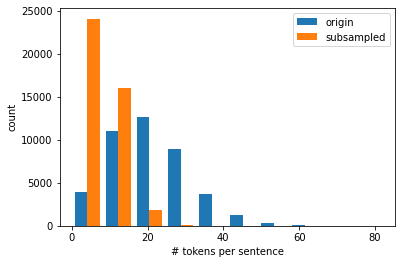

In [ ]:
plt.hist([
          [len(x) for x in sentences], 
          [len(x) for x in subsampled]
          ])
plt.xticks([0,20,40,60,80])
plt.xlabel("# tokens per sentence")
plt.ylabel('count')
plt.legend(['origin', 'subsampled'])
plt.show()

개별 토큰에 대해서, "the"가 추출될 확률도 1/20이 됐다.

반면 join은 유지됐다.

In [ ]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in sentences])}, '
            f'after={sum([l.count(token) for l in subsampled])}')

print(compare_counts('the'))
print(compare_counts('join'))

# of "the": before=50770, after=2056
# of "join": before=45, after=45


다음의 코드로 말뭉치의 index로 바꿔주었다.

In [ ]:
corpus = [vocab[line] for line in subsampled]

print(subsampled[1])
print(corpus[1])

['join', 'the', 'board']
[3228, 6079, 710]


### 3) Extracting Center Words and Context Words

다음 함수로 모든 중심 단어와 그에 따른 문맥 단어를 추출한다.

1부터 max_window_size까지의 정수를 context window size로 랜덤으로 균일하게 샘플링한다.

어떤 center word에서 샘플링된 context window size를 초과하지 않으면 context 단어 이다.

In [ ]:
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []

    # 개별 말뭉치에 대해서
    for line in corpus:
        # 2 단어가 안되면 버림
        if len(line) < 2:
            continue

        # 중심 단어에다가 모든 단어들 추가해두고
        centers += line
        # 중심 단어에 따른 문맥 단어들을 추가해준다.
        for i in range(len(line)):  # Context window centered at `i`
            # window size는 1부터 max까지 랜덤하게 설정하고
            window_size = random.randint(1, max_window_size)
            # 그 값을 알아서 sampling 한다.
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 중심 단어가 문맥 단어에 동시에 포함되면 안되니 그 단어는 버리고
            indices.remove(i)
            # 최종 문맥 단어를 추가한다.
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

잘 되는지 보자.

7글자, 3글자가 있는 문장이라고 생각하자.

max window size가 2일 경우, 결과는 다음과 같이 나올 수 있다.

In [ ]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [3, 4, 6]
center 6 has contexts [5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


window size는 5로 하자.

In [ ]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1502623'

### 4) Negative Sampling

negative sampling으로 추정 학습을 하자.

사전 정의된 분포에서 noise 단어를 추출하기 위해서,<br>sampling distribution이 sampling weight를 따르는 Random Generator Class를 정의하자.

In [ ]:
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights):
        # 1부터 Sampling Weights의 길이까지
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        # i와 candidates의 길이가 같으면,아래를 실행한다.
        if self.i == len(self.candidates):
            # 1부터 sampling weight까지의 숫자들을
            # sampling weight의 비율을 맞추도록
            # 10,000개의 단어를 내보낸다.
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            # 이후 i를 다시 0으로 세팅하며 마무리한다.
            self.i = 0
        # i를 업데이트한다.
        self.i += 1
        # self.candidates에서 랜덤하게 뽑은 단어들 중에서 i -1 을 내뱉는다.
        return self.candidates[self.i - 1]

아래의 코드는 [1,2,3]을 뽑을 수 있으며,

각각의 뽑힐 확률은 [2/9, 3/9, 4/9] 이다.

이 때 10번 반복해서 추출하면 다음과 같다.

In [ ]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 2, 3, 3, 2, 3, 2, 3, 2, 1]

중심 단어와 문맥 단어에 대해서, 랜덤하고 K개의 noise 단어를 뽑아야 한다.

W2V 논문의 제안에 따르면, noise word $w$를 추출하는 확률 $P(w)$는 그 단어의 상대 빈도에 0.75 제곱이다.

In [ ]:
def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""

    # Sampling Weight는 단어의 숫자만큼 만들고, 각 단어 빈도의 0.75 제곱이다.
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]

    # all_negatives는 빈 리스트이고
    # generator는 sampling weight를 반영한 Random Generator이다.
    all_negatives, generator = [], RandomGenerator(sampling_weights)

    # 모든 문장들에 대해서,
    for contexts in all_contexts:
        negatives = []
        
        # negative의 길이가 문장 길이 * K보다 작으면
        while len(negatives) < len(contexts) * K:
            # 랜덤하게 추출해서
            neg = generator.draw()
            # 원래 문장에 없는 단어이면
            if neg not in contexts:
                # 추가하고 아니면 버림
                negatives.append(neg)
        # 완성된 negative 문장은 all_negatives에 추가하고
        all_negatives.append(negatives)
    # 모든 문장에 대해서 시행이 완료되면 반환한다.
    return all_negatives

# 모든 context vecotrs, vocab, counter와 K=5로 세팅
all_negatives = get_negatives(all_contexts, vocab, counter, 5)

In [ ]:
# 길이가 3인 문장은 5배 하여 15개로 채움
print(len(all_contexts[0]), len(all_negatives[0]))
print(len(all_contexts[1]), len(all_negatives[1]))
print(len(all_contexts[2]), len(all_negatives[2]))

2 10
2 10
2 10


### 5) Loading Trainig Examples in Minibatches

모든 중심 단어와 문맥 단어, noise 단어들을 추출한 후에, 학습동안 반복적으로 추출하기 위해 minibatch로 만들어야 한다.

minibatch에서, i번째 example은 중심 단어와 $n_i$ 문맥 단어, $m_i$ noise 단어를 포함한다.

다양한 문맥 단어 크기 때문에, $n_i + m_i$는 i에 따라서 다른다.

따라서, 개별 예제에 대해서 문맥 단어와 noise 단어를 contexts_negatives라는 변수에 합치고, $max_i n_i+m_i$길이 만큼 0으로 채운다.

0은 loss 계산에서 제외하기 위해서, mask 변수를 선언한다.

contexts_negatives라는 변수에 패딩에 맞는 0짜리 mask에 대해서, contexts_negatives에 있는 마스크와 원소는 1:1로 매칭된다.

positive 와 negative 변수를 구별하기 위해서, contexts_negatives에 있는 noise 단어로부터 context words를 분리한다.

mask와 비슷하게, label과 context_negatives에 맞는 원소들 사이에 label이면 1이고 패딩이면 0이도록 마스킹 한다.

위의 아이디어는 batchify 함수로 구현됐다.

batch size 길이에 맞게 리스트로 넣고, 중심 단어, 문맥 단어, noise 단어들을 구성하도록 원소를 만든다.

In [ ]:
def batchify(data):

    # 문장의 최대 길이를 계산해야 한다 : window size가 랜덤이기 때문에, 제일 큰 값을 기준으로 잡는다.
    max_len = max(len(c) + len(n) for _, c, n in data)
    # 중심 단어, 문맥 단어, 마스크 (패딩 지우기) , labels(실제 문맥 단어)
    centers, contexts_negatives, masks, labels = [], [], [], []

    # 주어진 데이터는 [중심단어, 문맥단어, noise 단어]를 문장 단위로 주고
    for center, context, negative in data:
        # 현재 길이는 문맥 단어 길이 + nosie 단어 길이이다.
        cur_len = len(context) + len(negative)
        # 일단 중심 단어에다가는 중심 단어들 추가해두고
        centers += [center]
        
        # context + negative를 한 후에, max_len보다 부족한 수는 0으로 패딩으로 채운다.
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]

        # 그럼 0은 사실상 의미없는 단어이기 때문에, masking을 해줘야 한다.
        # 따라서 의미 있는 단어는 1로 채워 가져오고, 의미 없는 단어는 0으로 채워 가져온다.
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]

        # 그리고 loss함수 계산할 때, 문맥 단어랑 noise 단어는 따로 계산했었다.
        # 그에 대한 마스킹 처리를 해준다.
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    
    # 모든 문장에 대해서 완료되면, tensor로 변환해서 본다.
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [ ]:
%%time

x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])
CPU times: user 3.41 ms, sys: 41 µs, total: 3.45 ms
Wall time: 3.81 ms


### 6) Putting All Things Together

In [ ]:

def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """데이터 불러오기"""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()

    vocab = Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify,
                                      num_workers=num_workers)
    return data_iter, vocab

In [ ]:
%%time

data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])
CPU times: user 14.7 s, sys: 262 ms, total: 15 s
Wall time: 15.1 s


### 7) 요약
- 고빈도 단어는 학습에 유용하지 않다.<br>학습 속도 향상을 위해 뽑아내야 한다.

- 계산 효율을 위해, minibatch 단위로 데이터를 뽑는다.<br>padding과 non 패딩으로 변수를 구분하고, positive 예제와 negative 예제로 분리한다.

## 15.4 Pretraining Word2Vec

### Introduction

Skip-Gram 모델을 만들어보자.

그러고 PTB 데이터로 negative sampling을 활용해서 word2vec을 사전학습 할 것이다.

### 1) The Skip-Gram Model

Embedding Layer와 Batch Matrix 연산으로 Skip-Gram 모델을 만들자.

우선, embedding layer가 작동하는 것부터 보자.

**(1) Embedding Layer**

Embedding Layer는 token의 index로 feature vector에 매핑한다.

layer의 weight는 matrix이고<br>row의 수는 단어 사전의 크기와 동일하고(input_dim)<br>columns의 수는 개별 토큰의 벡터와 동일하다.

In [ ]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


embdding layer의 input은 단어 token의 index이다.

어떤 토큰 index i에 대해서, vector representation은 embedding layer에서 weight matrixdml i번째 row에서 얻을 수 있다.

vector dimension을 4로 설정했기 때문에, (2,3)의 minibatch token에 대해서 (2,3,4)의 벡터를 반환한다.

In [ ]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[ 2.2329, -0.4490,  1.8511, -0.3472],
         [-0.8467, -0.5936, -1.2526, -0.6882],
         [ 0.0939, -0.4390,  0.9516, -0.4169]],

        [[-0.0582,  1.2687, -1.1308,  1.0305],
         [ 0.1055, -0.9912,  0.9447, -1.1573],
         [ 0.0940,  0.6034,  0.5385, -1.5726]]], grad_fn=<EmbeddingBackward0>)

**(2) Defining the Forward Propagation**

순전파에서, skip-gram 모델의 input은 center word (batch_size, 1)의 모양과<br> context와 noise word를 합친 contexts_and_negatives의 (batch_size, max_len)이다.

두 변수는 우선 embedding layer에서 vector로 변환되고, 행렬곱으로 output을 반환한다 (batch_size, 1, max_len)

output의 각 원소는 중심 단어 벡터와 문맥 혹은 noise 단어 벡터의 점곱이다.

In [ ]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [ ]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

### 2) Training

### (1) Binary Cross-Entropy Loss

In [ ]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [ ]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

### (2) Initializing Model Parameters

중심 단어와 문맥 단어로 사용될 때 단어 사전의 모든 단어에 대한 Embedding Layer를 정의했다.

emb_size는 100으로 설정하자.

In [ ]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

### (3) Defining the Training Loop

In [ ]:
def train(net, data_iter, lr, num_epochs, device='cuda:0'):
    # Embedding의 Weight를 xavier로 초기화
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)

    # 초기화 적용
    net.apply(init_weights)

    # 모델을 cpu나 cuda에 올리고
    net = net.to(device)
    
    # Optimizer 설정
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # Animator는 보여주면 좋으니 설정해두고
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])

    # loss를 저장할 공간을 2개로 생성 [0.0, 0.0]
    metric = d2l.Accumulator(2)

    for epoch in range(num_epochs):
        # Timer로 시간 측정하면서, 총 배치 길이 가져오고
        timer, num_batches = d2l.Timer(), len(data_iter)

        # data_iter에서 batch 단위로 데이터 추출
        for i, batch in enumerate(data_iter):

            # optimizer 초기화
            optimizer.zero_grad()

            # batch에서 각각 추출하면서 device에 올리고, 변수에 저장
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            # skip_gram에 중심 단어 토큰, 문맥+noise 단어 토큰, Emb1, Emb2 넣고
            pred = skip_gram(center, context_negative, net[0], net[1])

            # Loss는 Masking을 적용해서 계산해서
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            
            # gradient 계산
            l.sum().backward()

            # 파라미터 갱신
            optimizer.step()

            # metric에 현재 batch에 대한 상태 업로드
            metric.add(l.sum(), l.numel())

            # Animator에 추가
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    # 학습 완료시의 Loss와 Metric 반환
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

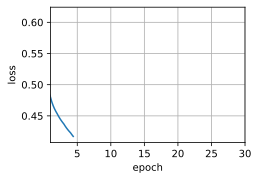

In [ ]:
lr, num_epochs = 0.002, 30
train(net, data_iter, lr, num_epochs, 'cuda:0')

## 3) Applying Word Embeddings

W2V 학습 이후, 단어 벡터들 사이의 코사인 유사도로 의미론적으로 유사한 input 단어들을 사용할 수 있다.

In [ ]:
def get_similar_tokens(query_token, k, embed):
    # Embedding 된 단어 들
    W = embed.weight.data

    # 특정 단어에 대한 Vector
    x = W[vocab[query_token]]

    # Cosine 유사도 계산
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    
    # Cosine 유사도 중 top K개의 단어들을 뽑아와서
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')

    # 유사도와 그 단어 출력
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('Book', 3, net[0])

## 4) Summary

- Binary Cross Entropy Loss와 Embedding Layer를 활용해서 Negative Sampling을 활용한 Skip-Gram 모델을 학습했다.

- 단어 벡터들의 코사인 유사도를 기반으로 주어진 단어에 대한 의미론적으로 유사한 단어를 찾아내는 것을 포함하여 Word Embedding의 적용 가능